## _*Hamiltonian and Gate Characterization*_ 


This notebook looks at characterization of Hamiltonian terms and at characterizing coherent gate errors

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from qiskit.ignis.characterization.hamiltonian import ZZFitter, zz_circuits

# Measuring ZZ

**Theory**

The desired Hamiltonian (with no interactions) is 

$H=\sum_{i} \omega_i |1\rangle\langle1|$

However, in any practical system with coupling, there will unwanted interaction terms. One common term is a ZZ interaction, which we typically write out as an energy shift on the $|11\rangle$ state,

$H=\omega_0 (1-\sigma_{Z,0})/2 +\omega_1 (1-\sigma_{Z,1})/2 + \xi |11\rangle\langle 11|$

** Experiment **

The experiment to measure $\xi$ is to perform a Ramsey experiment on Q0 (H-t-H) and repeat the Ramsey with Q1 in the excited state. The difference in frequency between these experiments is the rate $\xi$

In [85]:
# ZZ rates are typically ~ 100kHz so we want Ramsey oscillations around 1MHz
# 12 numbers ranging from 10 to 1000, logarithmically spaced
# extra point at 1500
num_of_gates = np.arange(0,150,5)
gate_time = 0.1

# Select the qubits whose ZZ will be measured
qubits = [0]
spectators = [1]

# Generate experiments
circs, xdata, osc_freq = zz_circuits(num_of_gates, gate_time, qubits, spectators, nosc=2)

One of the features of the fitters are that we can split the circuits into multiple jobs and then give the results to the fitter as a list. Demonstrated below.

In [86]:
# Set the simulator with ZZ
zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = np.exp(1j*2*np.pi*0.02*gate_time)
error = coherent_unitary_error(zz_unitary)
noise_model = NoiseModel()
noise_model.add_nonlocal_quantum_error(error, 'id', [0], [0,1])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

ZZ Rate: 19.730088 kHz


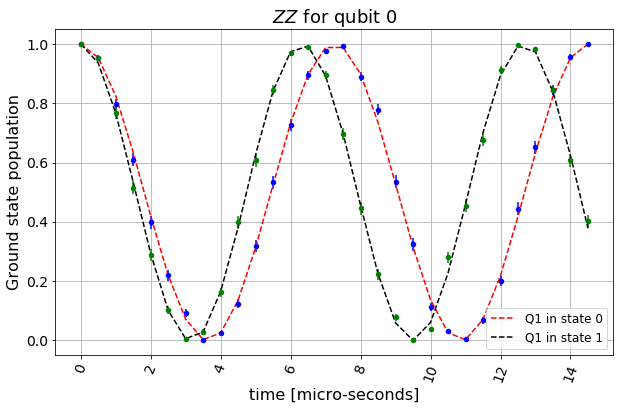

In [89]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_a = 1
initial_c = 0
initial_f = osc_freq 
initial_phi = -np.pi/20

fit = ZZFitter(backend_result1, xdata, qubits, spectators,
                   fit_p0=[initial_a, initial_f, initial_phi, initial_c],
                   fit_bounds=([-0.5, 0, -np.pi, -0.5],
                               [1.5, 2*osc_freq, np.pi, 1.5]))

fit.plot_ZZ(0, ax=plt.gca())
    
print("ZZ Rate: %f kHz"%(fit.ZZ_rate()[0]*1e3))
plt.show()